In [1]:
import pandas as pd
import numpy as np

In [2]:
# 文件路径
train_file_path = "Xy_train.csv"
val_file_path = "Xy_val.csv"
test_file_path = "Xy_test.csv"

# 读取数据
train_data = pd.read_csv(train_file_path)
val_data = pd.read_csv(val_file_path)
test_data = pd.read_csv(test_file_path)

# 分离特征和目标
X_train = train_data.drop(columns=['target']).values
y_train = train_data['target'].values

X_val = val_data.drop(columns=['target']).values
y_val = val_data['target'].values

X_test = test_data.drop(columns=['target']).values
y_test = test_data['target'].values


# 确认读取结果
print("Train data shape:", X_train.shape, "Target shape:", y_train.shape)
print("Validation data shape:", X_val.shape, "Target shape:", y_val.shape)
print("Test data shape:", X_test.shape, "Target shape:", y_test.shape)

Train data shape: (578421, 9) Target shape: (578421,)
Validation data shape: (123949, 9) Target shape: (123949,)
Test data shape: (123947, 9) Target shape: (123947,)


In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [4]:
# 加载目标值归一化器
target_scaler = joblib.load("target_scaler.pkl")

# 初始化模型
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度，值越大正则化越强

# 训练模型（仅使用训练集）
linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# 在测试集上预测
y_test_pred_linear = linear_model.predict(X_test)
y_test_pred_ridge = ridge_model.predict(X_test)

# 在验证集上预测
y_val_pred_linear = linear_model.predict(X_val)
y_val_pred_ridge = ridge_model.predict(X_val)

# 反归一化目标值和预测值
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_linear_original = target_scaler.inverse_transform(y_test_pred_linear.reshape(-1, 1)).flatten()
y_test_pred_ridge_original = target_scaler.inverse_transform(y_test_pred_ridge.reshape(-1, 1)).flatten()

y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_val_pred_linear_original = target_scaler.inverse_transform(y_val_pred_linear.reshape(-1, 1)).flatten()
y_val_pred_ridge_original = target_scaler.inverse_transform(y_val_pred_ridge.reshape(-1, 1)).flatten()

# 评估性能
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print("-" * 30)

# 测试集性能评估（反归一化后的值）
evaluate_model(y_test_original, y_test_pred_linear_original, "Linear Regression (Test Set)")
evaluate_model(y_test_original, y_test_pred_ridge_original, "Ridge Regression (Test Set)")

# 验证集性能评估（反归一化后的值）
evaluate_model(y_val_original, y_val_pred_linear_original, "Linear Regression (Validation Set)")
evaluate_model(y_val_original, y_val_pred_ridge_original, "Ridge Regression (Validation Set)")


Linear Regression (Test Set) Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0018
R^2 Score: -0.4999
------------------------------
Ridge Regression (Test Set) Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0018
R^2 Score: -0.4999
------------------------------
Linear Regression (Validation Set) Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.4160
------------------------------
Ridge Regression (Validation Set) Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.4160
------------------------------


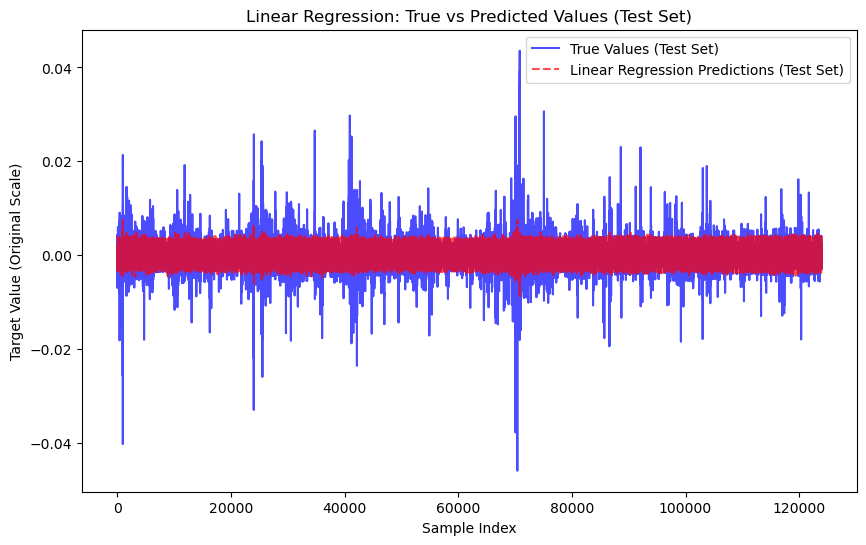

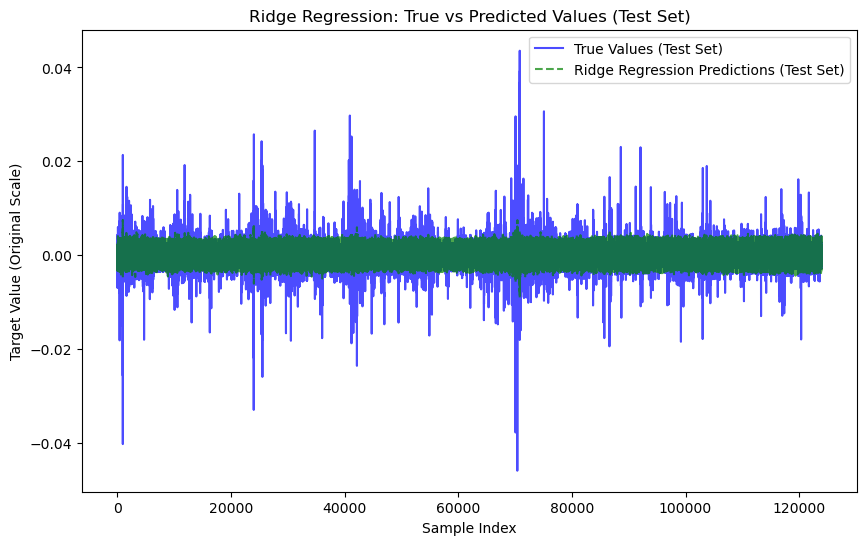

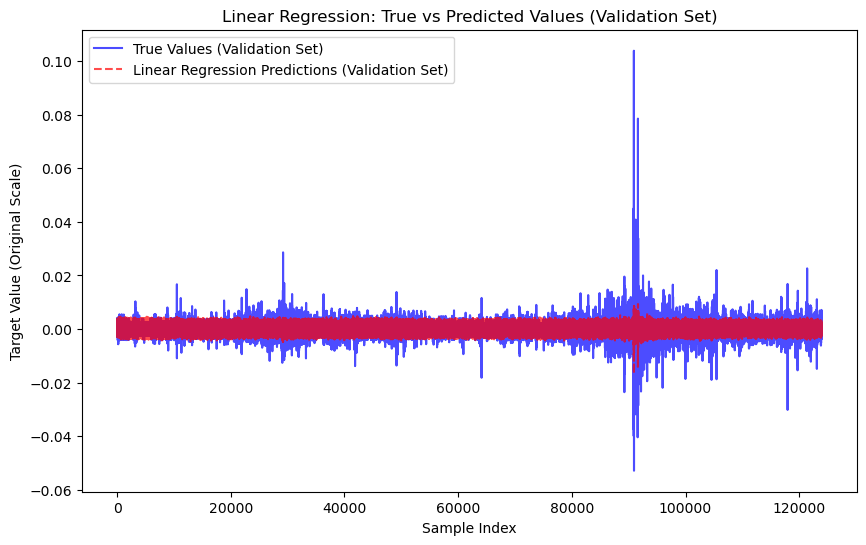

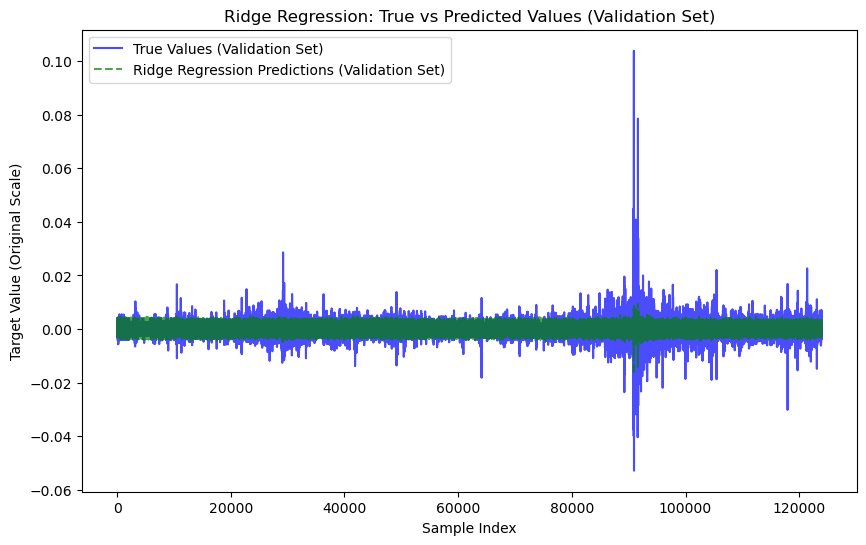

In [5]:
import matplotlib.pyplot as plt

# Plot for Test Set: Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="True Values (Test Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_test_pred_linear_original, label="Linear Regression Predictions (Test Set)", color="red", linestyle="--", alpha=0.7)  # Predictions
plt.title("Linear Regression: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Test Set: Ridge Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="True Values (Test Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_test_pred_ridge_original, label="Ridge Regression Predictions (Test Set)", color="green", linestyle="--", alpha=0.7)  # Predictions
plt.title("Ridge Regression: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Validation Set: Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="True Values (Validation Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_val_pred_linear_original, label="Linear Regression Predictions (Validation Set)", color="red", linestyle="--", alpha=0.7)  # Predictions
plt.title("Linear Regression: True vs Predicted Values (Validation Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Validation Set: Ridge Regression
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="True Values (Validation Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_val_pred_ridge_original, label="Ridge Regression Predictions (Validation Set)", color="green", linestyle="--", alpha=0.7)  # Predictions
plt.title("Ridge Regression: True vs Predicted Values (Validation Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


XGBoost Performance (Test Set):
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0632
Correlation Coefficient: 0.0636
------------------------------
XGBoost Performance (Validation Set):
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0577
Correlation Coefficient: 0.0510
------------------------------


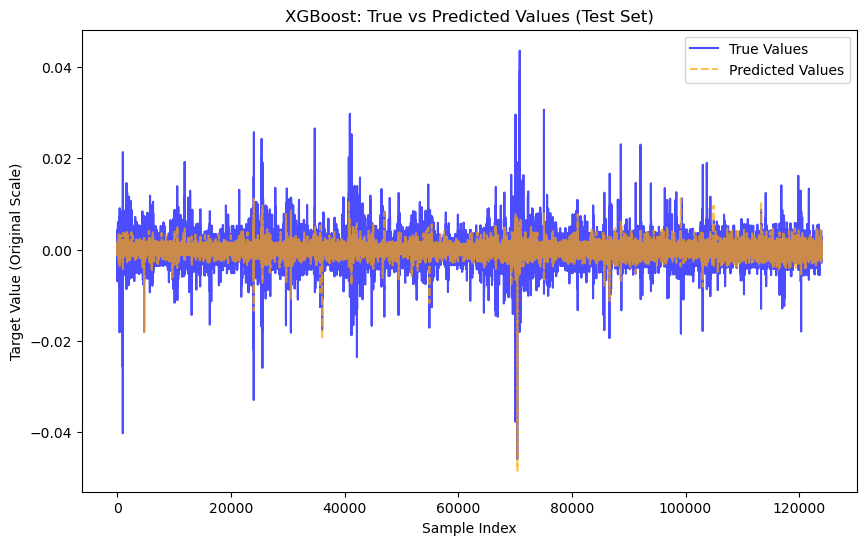

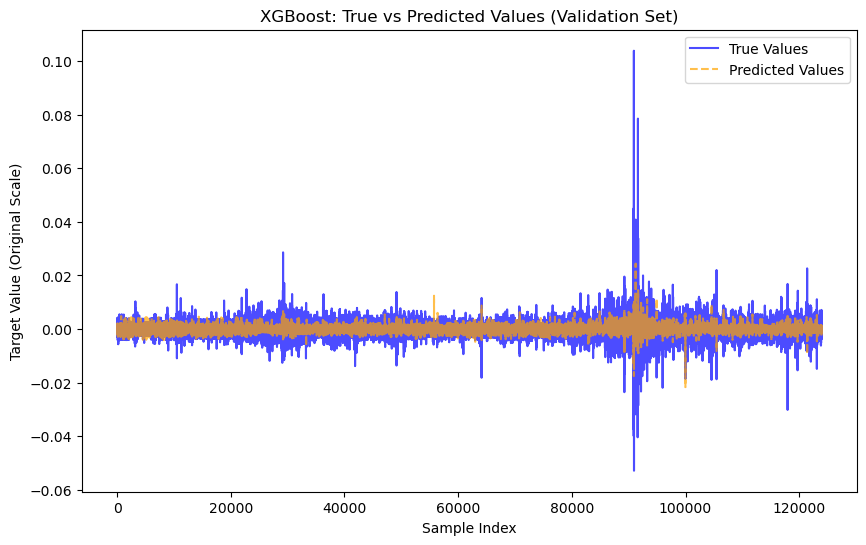

In [6]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 加载目标值归一化器
target_scaler = joblib.load("target_scaler.pkl")

# 定义模型
models = {
    "XGBoost": XGBRegressor(),
}

# 存储预测结果
predictions = {}

# 性能评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]  # 计算皮尔逊相关系数
    
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Correlation Coefficient: {correlation:.4f}")  # 输出相关系数
    print("-" * 30)

for model_name, model in models.items():
    # 模型训练
    model.fit(X_train, y_train)
    
    # 测试集预测
    y_test_pred = model.predict(X_test)
    y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    
    # 验证集预测
    y_val_pred = model.predict(X_val)
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
    
    # 存储预测结果
    predictions[model_name] = {
        "y_test_pred": y_test_pred_original,
        "y_val_pred": y_val_pred_original
    }
    
    # 性能评估
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    
    print(f"{model_name} Performance (Test Set):")
    evaluate_model(y_test_original, y_test_pred_original, model_name)
    
    print(f"{model_name} Performance (Validation Set):")
    evaluate_model(y_val_original, y_val_pred_original, model_name)

# 可视化函数
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True Values", color="blue", alpha=0.7)
    plt.plot(y_pred, label="Predicted Values", color="orange", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value (Original Scale)")
    plt.legend()
    plt.show()

# 可视化所有模型预测结果
for model_name, preds in predictions.items():
    plot_predictions(
        y_test_original, preds["y_test_pred"], 
        f"{model_name}: True vs Predicted Values (Test Set)"
    )
    plot_predictions(
        y_val_original, preds["y_val_pred"], 
        f"{model_name}: True vs Predicted Values (Validation Set)"
    )


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_26544\4068419149.py:68: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_period_return / std_period_return) * np.sqrt(points_per_year)


Top 10 Strategies by Annualized Return:
Upper Percentile: 99.57999999999979 | Lower Percentile: 0.0 | Annualized Return: 107.4753% | Sharpe Ratio: 4.07 | Turnover: 1085.19
Upper Percentile: 99.6099999999998 | Lower Percentile: 0.0 | Annualized Return: 98.0423% | Sharpe Ratio: 3.87 | Turnover: 990.26
Upper Percentile: 99.52999999999976 | Lower Percentile: 0.0 | Annualized Return: 97.9029% | Sharpe Ratio: 3.65 | Turnover: 1206.72
Upper Percentile: 99.6199999999998 | Lower Percentile: 0.0 | Annualized Return: 97.5390% | Sharpe Ratio: 3.86 | Turnover: 961.23
Upper Percentile: 99.62999999999981 | Lower Percentile: 0.0 | Annualized Return: 97.3218% | Sharpe Ratio: 3.86 | Turnover: 937.81
Upper Percentile: 99.51999999999975 | Lower Percentile: 0.0 | Annualized Return: 96.4746% | Sharpe Ratio: 3.59 | Turnover: 1228.11
Upper Percentile: 99.5999999999998 | Lower Percentile: 0.0 | Annualized Return: 94.3079% | Sharpe Ratio: 3.72 | Turnover: 1005.05
Upper Percentile: 99.58999999999979 | Lower Perc

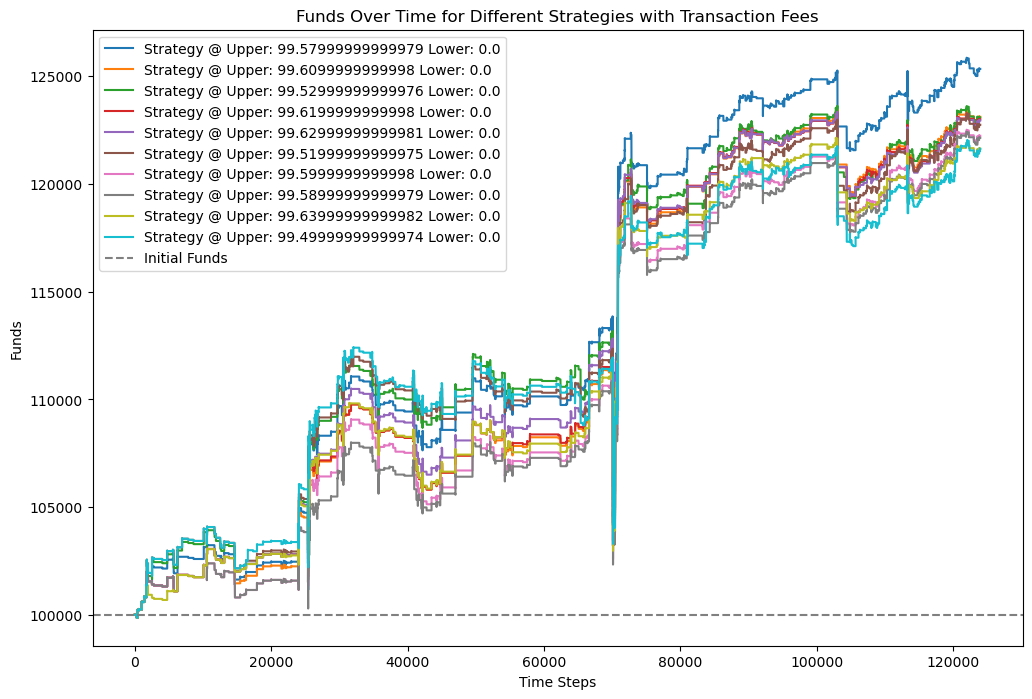

In [29]:
initial_funds =100000
transaction_fee_rate = 0.00025  # 交易费用率

def trade_strategy(y_pred, y_test, upper_percentile, lower_percentile):
    """
    根据上下分位点执行交易策略，包含买入和卖出逻辑，计算各项指标。
    """
    # 计算上下阈值
    upper_threshold = np.percentile(y_pred, upper_percentile)
    lower_threshold = np.percentile(y_pred, lower_percentile)
    
    funds = initial_funds  # 初始资金
    funds_over_time = []  # 资金变化记录
    total_fees = 0.0  # 总交易费用
    trade_count = 0  # 总交易次数
    daily_trade_counts = []  # 每日交易次数
    total_volume = 0.0  # 累计交易额
    previous_allocation = 0.0  # 初始仓位
    previous_funds = funds  # 上期资金
    periodic_returns = []  # 收益率记录

    # 记录每日交易次数
    daily_trade_count = 0

    # 模拟交易
    for i, pred in enumerate(y_pred):
        actual_return = y_test[i]

        # 根据预测值决定当前仓位
        if pred > upper_threshold:
            allocation = 1.0  # 做多
        elif pred < lower_threshold:
            allocation = -1.0  # 做空
        else:
            allocation = 0.0  # 空仓

        # 如果仓位有变化，处理买入或卖出逻辑
        if allocation != previous_allocation:
            # 计算交易金额
            trade_amount = funds * abs(allocation - previous_allocation)
            fee = trade_amount * transaction_fee_rate  # 交易费用
            total_fees += fee
            funds -= fee  # 扣除费用
            total_volume += trade_amount
            trade_count += 1
            daily_trade_count += 1  # 记录当天的交易次数

        # 根据仓位计算收益
        if allocation != 0:
            funds *= (1 + allocation * actual_return)

        funds_over_time.append(funds)

        # 记录本期收益率
        if i > 0:
            period_return = (funds - previous_funds) / previous_funds
            periodic_returns.append(period_return)

        previous_funds = funds
        previous_allocation = allocation

        # 每天结束时记录交易次数
        if (i + 1) % points_per_day == 0:
            daily_trade_counts.append(daily_trade_count)
            daily_trade_count = 0

    # 若最后一天未满一天步数，则补充剩余的交易次数
    if daily_trade_count > 0:
        daily_trade_counts.append(daily_trade_count)

    # 总周期数
    total_periods = len(y_pred)

    # 单利年化收益率计算
    total_return = (funds - initial_funds) / initial_funds
    annualized_return = total_return * (points_per_year / total_periods)

    # 夏普比率计算
    if len(periodic_returns) > 1:
        mean_period_return = np.mean(periodic_returns)
        std_period_return = np.std(periodic_returns)
        sharpe_ratio = (mean_period_return / std_period_return) * np.sqrt(points_per_year)
    else:
        sharpe_ratio = 0.0

    # 最大回撤
    if len(funds_over_time) > 1:
        cummax = np.maximum.accumulate(funds_over_time)
        drawdowns = 1 - np.array(funds_over_time) / cummax
        max_drawdown = np.max(drawdowns)
    else:
        max_drawdown = 0.0

    # 平均每日交易次数
    avg_daily_trades = np.mean(daily_trade_counts)

    return {
        "funds_over_time": funds_over_time,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "upper_percentile": upper_percentile,
        "lower_percentile": lower_percentile,
        "avg_daily_trades": avg_daily_trades
    }


upper_percentiles = np.arange(100.0, 98.0, -0.01)  
lower_percentiles = np.arange(0.0, 0.5, 0.1)    

# 存储每种策略的结果
strategies_results = []

# 遍历上限和下限分位点的组合
for upper_percentile in upper_percentiles:
    for lower_percentile in lower_percentiles:
        if upper_percentile > lower_percentile:  # 确保有效的上下阈值
            result = trade_strategy(y_test_pred_original, y_test_original, upper_percentile, lower_percentile)
            strategies_results.append(result)
# 筛选年化收益最高的前 10 个策略
top_10_return = sorted(strategies_results, key=lambda x: x["annualized_return"], reverse=True)[:10]

# 筛选夏普比率最高的前 10 个策略
top_10_sharpe = sorted(strategies_results, key=lambda x: x["sharpe_ratio"], reverse=True)[:10]

# 打印结果
print("Top 10 Strategies by Annualized Return:")
for result in top_10_return:
    print(f"Upper Percentile: {result['upper_percentile']} | Lower Percentile: {result['lower_percentile']} | "
          f"Annualized Return: {result['annualized_return']:.4%} | Sharpe Ratio: {result['sharpe_ratio']:.2f} | "
          f"Turnover: {result['turnover']:.2f}")

print("\nTop 10 Strategies by Sharpe Ratio:")
for result in top_10_sharpe:
    print(f"Upper Percentile: {result['upper_percentile']} | Lower Percentile: {result['lower_percentile']} | "
          f"Annualized Return: {result['annualized_return']:.4%} | Sharpe Ratio: {result['sharpe_ratio']:.2f} | "
          f"Turnover: {result['turnover']:.2f}")

# 可视化结果
plt.figure(figsize=(12, 8))
for result in top_10_return : # 可视化前 5 个策略
    plt.plot(result["funds_over_time"], label=f"Strategy @ Upper: {result['upper_percentile']} Lower: {result['lower_percentile']}")
plt.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
plt.title("Funds Over Time for Different Strategies with Transaction Fees")
plt.xlabel("Time Steps")
plt.ylabel("Funds")
plt.legend()
plt.show()

# date
# github
# 15s
# other crypto 20
# In sample 
# Turnover
# Price

Top 10 Strategies by Annualized Return:
Upper Percentile: 99.60000000000002 | Lower Percentile: 0.1 | Annualized Return: -1.9516% | Sharpe Ratio: 0.06 | Average Daily Trades: 13.00
Upper Percentile: 99.50000000000003 | Lower Percentile: 0.1 | Annualized Return: -4.0720% | Sharpe Ratio: -0.01 | Average Daily Trades: 15.47
Upper Percentile: 99.40000000000003 | Lower Percentile: 0.1 | Annualized Return: -5.5658% | Sharpe Ratio: -0.05 | Average Daily Trades: 18.02
Upper Percentile: 99.60000000000002 | Lower Percentile: 0.2 | Annualized Return: -14.6040% | Sharpe Ratio: -0.39 | Average Daily Trades: 15.29
Upper Percentile: 99.80000000000001 | Lower Percentile: 0.1 | Annualized Return: -15.4041% | Sharpe Ratio: -0.52 | Average Daily Trades: 7.81
Upper Percentile: 99.50000000000003 | Lower Percentile: 0.2 | Annualized Return: -16.6608% | Sharpe Ratio: -0.43 | Average Daily Trades: 17.74
Upper Percentile: 99.70000000000002 | Lower Percentile: 0.1 | Annualized Return: -17.6404% | Sharpe Ratio: 

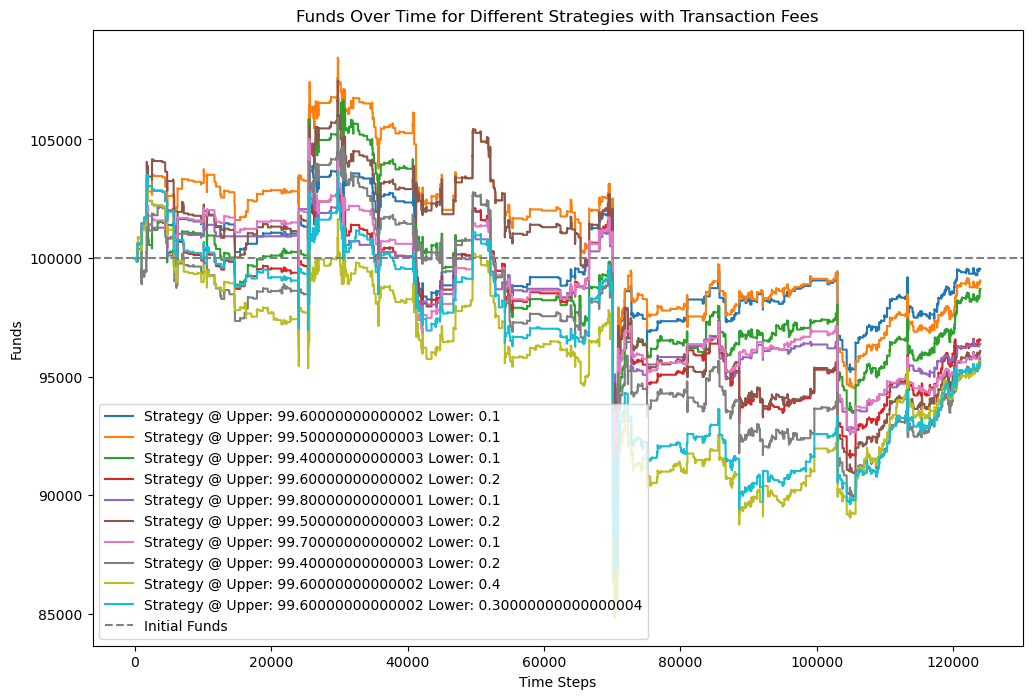

In [31]:
initial_funds = 100000
transaction_fee_rate = 0.00025  # 交易费用率
points_per_day = 1440  # 每天的分钟数（假设数据是分钟级）

def trade_strategy(y_pred, y_test, upper_percentile, lower_percentile):
    """
    根据上下分位点执行交易策略，包含多头和空头逻辑，计算各项指标。
    """
    # 计算上下阈值
    upper_threshold = np.percentile(y_pred, upper_percentile)
    lower_threshold = np.percentile(y_pred, lower_percentile)
    
    funds = initial_funds  # 初始资金
    funds_over_time = []  # 资金变化记录
    total_fees = 0.0  # 总交易费用
    trade_count = 0  # 总交易次数
    daily_trade_counts = []  # 每日交易次数
    total_volume = 0.0  # 累计交易额
    previous_allocation = 0.0  # 初始仓位
    previous_funds = funds  # 上期资金
    periodic_returns = []  # 收益率记录

    # 记录每日交易次数
    daily_trade_count = 0

    # 模拟交易
    for i, pred in enumerate(y_pred):
        actual_return = y_test[i]

        # 根据预测值决定当前仓位
        if pred > upper_threshold:
            allocation = 1.0  # 做多
        elif pred < lower_threshold:
            allocation = -1.0  # 做空
        else:
            allocation = 0.0  # 空仓

        # 如果仓位有变化，处理买入或卖出逻辑
        if allocation != previous_allocation:
            # 计算交易金额
            trade_amount = funds * abs(allocation - previous_allocation)
            fee = trade_amount * transaction_fee_rate  # 交易费用
            total_fees += fee
            funds -= fee  # 扣除费用
            total_volume += trade_amount
            trade_count += 1
            daily_trade_count += 1  # 记录当天的交易次数

        # 根据仓位计算收益
        if allocation == 1.0:  # 多头逻辑
            funds *= (1 + actual_return)
        elif allocation == -1.0:  # 空头逻辑
            funds *= (1 - actual_return)

        funds_over_time.append(funds)

        # 记录本期收益率
        if i > 0:
            period_return = (funds - previous_funds) / previous_funds
            periodic_returns.append(period_return)

        previous_funds = funds
        previous_allocation = allocation

        # 每天结束时记录交易次数
        if (i + 1) % points_per_day == 0:
            daily_trade_counts.append(daily_trade_count)
            daily_trade_count = 0

    # 若最后一天未满一天步数，则补充剩余的交易次数
    if daily_trade_count > 0:
        daily_trade_counts.append(daily_trade_count)

    # 总周期数
    total_periods = len(y_pred)

    # 单利年化收益率计算
    total_return = (funds - initial_funds) / initial_funds
    annualized_return = total_return * (points_per_year / total_periods)

    # 夏普比率计算
    if len(periodic_returns) > 1:
        mean_period_return = np.mean(periodic_returns)
        std_period_return = np.std(periodic_returns)
        sharpe_ratio = (mean_period_return / std_period_return) * np.sqrt(points_per_year)
    else:
        sharpe_ratio = 0.0

    # 最大回撤
    if len(funds_over_time) > 1:
        cummax = np.maximum.accumulate(funds_over_time)
        drawdowns = 1 - np.array(funds_over_time) / cummax
        max_drawdown = np.max(drawdowns)
    else:
        max_drawdown = 0.0

    # 平均每日交易次数
    avg_daily_trades = np.mean(daily_trade_counts)

    return {
        "funds_over_time": funds_over_time,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "upper_percentile": upper_percentile,
        "lower_percentile": lower_percentile,
        "avg_daily_trades": avg_daily_trades
    }


# 修改分位点范围
upper_percentiles = np.arange(100.0, 98.0, -0.1)  
lower_percentiles = np.arange(0.1, 0.6, 0.1)    

# 存储每种策略的结果
strategies_results = []

# 遍历上限和下限分位点的组合
for upper_percentile in upper_percentiles:
    for lower_percentile in lower_percentiles:
        if upper_percentile > lower_percentile:  # 确保有效的上下阈值
            result = trade_strategy(y_test_pred_original, y_test_original, upper_percentile, lower_percentile)
            strategies_results.append(result)

# 筛选年化收益最高的前 10 个策略
top_10_return = sorted(strategies_results, key=lambda x: x["annualized_return"], reverse=True)[:10]

# 筛选夏普比率最高的前 10 个策略
top_10_sharpe = sorted(strategies_results, key=lambda x: x["sharpe_ratio"], reverse=True)[:10]

# 打印结果
print("Top 10 Strategies by Annualized Return:")
for result in top_10_return:
    print(f"Upper Percentile: {result['upper_percentile']} | Lower Percentile: {result['lower_percentile']} | "
          f"Annualized Return: {result['annualized_return']:.4%} | Sharpe Ratio: {result['sharpe_ratio']:.2f} | "
          f"Average Daily Trades: {result['avg_daily_trades']:.2f}")

print("\nTop 10 Strategies by Sharpe Ratio:")
for result in top_10_sharpe:
    print(f"Upper Percentile: {result['upper_percentile']} | Lower Percentile: {result['lower_percentile']} | "
          f"Annualized Return: {result['annualized_return']:.4%} | Sharpe Ratio: {result['sharpe_ratio']:.2f} | "
          f"Average Daily Trades: {result['avg_daily_trades']:.2f}")

# 可视化结果
plt.figure(figsize=(12, 8))
for result in top_10_return:  # 可视化前 5 个策略
    plt.plot(result["funds_over_time"], label=f"Strategy @ Upper: {result['upper_percentile']} Lower: {result['lower_percentile']}")
plt.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
plt.title("Funds Over Time for Different Strategies with Transaction Fees")
plt.xlabel("Time Steps")
plt.ylabel("Funds")
plt.legend()
plt.show()


Percentile: 99%
Annualized Return: 266.8775%
Sharpe Ratio (Annualized): 0.00
Max Drawdown: 8.6487%
Average Daily Trades: nan
Average Daily Fees: nan
--------------------------------------------------


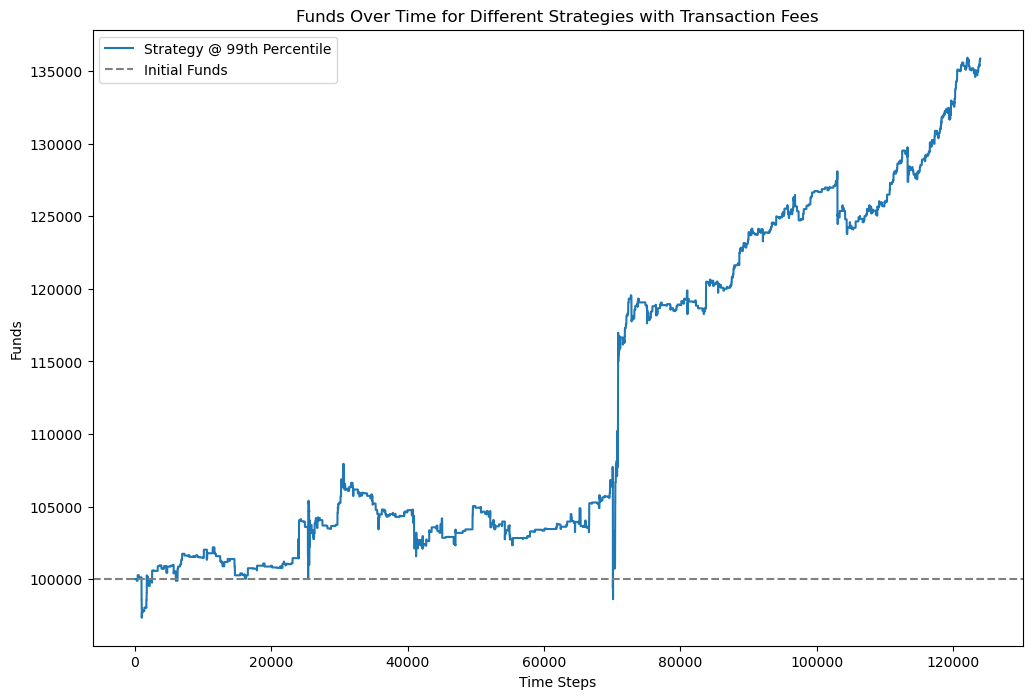

In [19]:
# 初始资金
initial_funds = 100000
transaction_fee_rate = 0.0003  # 万分之三
points_per_year = 525600  # 一年时间点数（分钟级数据）
trading_days_per_year = points_per_year / 1440  # 一年交易天数

# 定义交易策略函数
def trade_strategy(y_pred, y_test, percentile):
    """
    根据给定的分位点执行交易策略，加入交易费用，计算各项指标。
    """
    threshold = np.percentile(y_pred, percentile)  # 计算分位点
    funds = initial_funds  # 初始资金
    funds_over_time = []  # 记录资金变化
    total_fees = 0  # 累计交易费用
    trade_count = 0  # 总交易次数
    daily_trades = []  # 每日交易次数
    daily_fees = []  # 每日交易费用
    daily_returns = []  # 每日收益

    # 模拟交易
    for i, pred in enumerate(y_pred):
        # 实际收益率 (已经是 return.shift(-1))
        actual_return = y_test[i]

        # 判断是否交易
        if pred > threshold:
            allocation = 1.0  # 100% 资金
            trade_count += 1  # 增加交易次数
        else:
            allocation = 0.0  # 不交易

        # 计算交易费用
        trade_amount = funds * allocation
        fee = trade_amount * transaction_fee_rate if allocation > 0 else 0
        total_fees += fee

        # 计算收益
        profit = trade_amount * actual_return - fee
        funds += profit  # 更新资金
        funds_over_time.append(funds)

        # 记录每日数据


    # 年化收益
    total_periods = len(y_pred)
    annualized_return = (funds / initial_funds) ** (points_per_year / total_periods) - 1

    # 夏普比率 (年化)
    daily_returns = np.array(daily_returns)
    mean_daily_return = np.mean(daily_returns)
    std_daily_return = np.std(daily_returns)
    sharpe_ratio = (
        (mean_daily_return * trading_days_per_year) /
        (std_daily_return * np.sqrt(trading_days_per_year))
        if len(daily_returns) > 1 else 0
    )

    # 最大回撤
    max_drawdown = max(1 - np.array(funds_over_time) / np.maximum.accumulate(funds_over_time))

    # 打印结果
    print(f"Percentile: {percentile}%")
    print(f"Annualized Return: {annualized_return:.4%}")
    print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.4%}")
    print(f"Average Daily Trades: {np.mean(daily_trades):.2f}")
    print(f"Average Daily Fees: {np.mean(daily_fees):.2f}")
    print("-" * 50)

    return funds_over_time

# 分位点范围从 100 到 85
percentiles = [99]  # 从 100 到 85，步长为 -1

# 存储每种策略的资金变化
strategies_funds = {}

for percentile in percentiles:
    strategies_funds[percentile] = trade_strategy(y_test_pred_original, y_test_original, percentile)

# 可视化结果
plt.figure(figsize=(12, 8))
for percentile, funds_over_time in strategies_funds.items():
    plt.plot(funds_over_time, label=f"Strategy @ {percentile}th Percentile")
plt.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
plt.title("Funds Over Time for Different Strategies with Transaction Fees")
plt.xlabel("Time Steps")
plt.ylabel("Funds")
plt.legend()
plt.show()
# rolling_percentile rounding, turnover, plot time, returns